In [2]:
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import KFold, StratifiedKFold
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
from matplotlib import pyplot as plt

In [49]:
data = pd.read_csv('dataset/preprocessed/reshaped_pca98_df')
label = pd.read_csv('dataset/preprocessed/label')

In [56]:
X = np.array(data)
Y = np.array(label)

In [57]:
X = X[:, 1:]
Y = Y[:, 1:]

In [52]:
#Y = np.append(Y,Y, axis=0)

In [53]:
X.shape

(2076, 1603)

In [84]:
n_split = 10
input_dim = len(X)
stdv = np.std(X)

In [89]:
def create_model(input_dim, stdv):
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Dense(input_dim, activation = 'relu'))
  #model.add(tf.keras.layers.GaussianNoise(stdv))
  model.add(tf.keras.layers.Dense(500, activation = 'relu'))
  model.add(tf.keras.layers.Dropout(rate=0.2))
  model.add(tf.keras.layers.Dense(100, activation = 'relu'))
  model.add(tf.keras.layers.Dropout(rate=0.3))
  model.add(tf.keras.layers.Dense(10, activation = 'relu'))
  model.add(tf.keras.layers.Dense(4, activation = 'softmax'))

  model.compile(loss = 'sparse_categorical_crossentropy' , optimizer = 'adam' , metrics = ['accuracy'] )

  return model

In [90]:
history = []
eval = []
for train_index,test_index in KFold(n_split).split(X):
  x_train,x_test= X[train_index],X[test_index]
  y_train,y_test= Y[train_index],Y[test_index]

  model = create_model(1000, stdv)
  temp = model.fit(x_train, y_train, epochs= 50)
  history.append(temp)
  eval.append(model.evaluate(x_test,y_test))
  #print('Model evaluation ',model.evaluate(x_test,y_test))

Epoch 1/50
59/59 [==============================] - 1s 9ms/step - loss: 1.6654 - accuracy: 0.2430
Epoch 2/50
59/59 [==============================] - 1s 9ms/step - loss: 1.4079 - accuracy: 0.2479
Epoch 3/50
59/59 [==============================] - 1s 9ms/step - loss: 1.4219 - accuracy: 0.2355
Epoch 4/50
59/59 [==============================] - 1s 8ms/step - loss: 1.3941 - accuracy: 0.2468
Epoch 5/50
59/59 [==============================] - 0s 8ms/step - loss: 1.3995 - accuracy: 0.2388
Epoch 6/50
59/59 [==============================] - 1s 9ms/step - loss: 1.3872 - accuracy: 0.2302
Epoch 7/50
59/59 [==============================] - 1s 9ms/step - loss: 1.3867 - accuracy: 0.2505
Epoch 8/50
59/59 [==============================] - 1s 9ms/step - loss: 1.3890 - accuracy: 0.2382
Epoch 9/50
59/59 [==============================] - 1s 9ms/step - loss: 1.3890 - accuracy: 0.2516
Epoch 10/50
59/59 [==============================] - 1s 11ms/step - loss: 1.3948 - accuracy: 0.2511
Epoch 11/50
59/59 

In [91]:
print('Average eval Loss:', np.average([x[0] for x in eval]))
print('Average eval Acc:', np.average([x[1] for x in eval]))

Average eval Loss: 1.3864493370056152
Average eval Acc: 0.24132757335901261


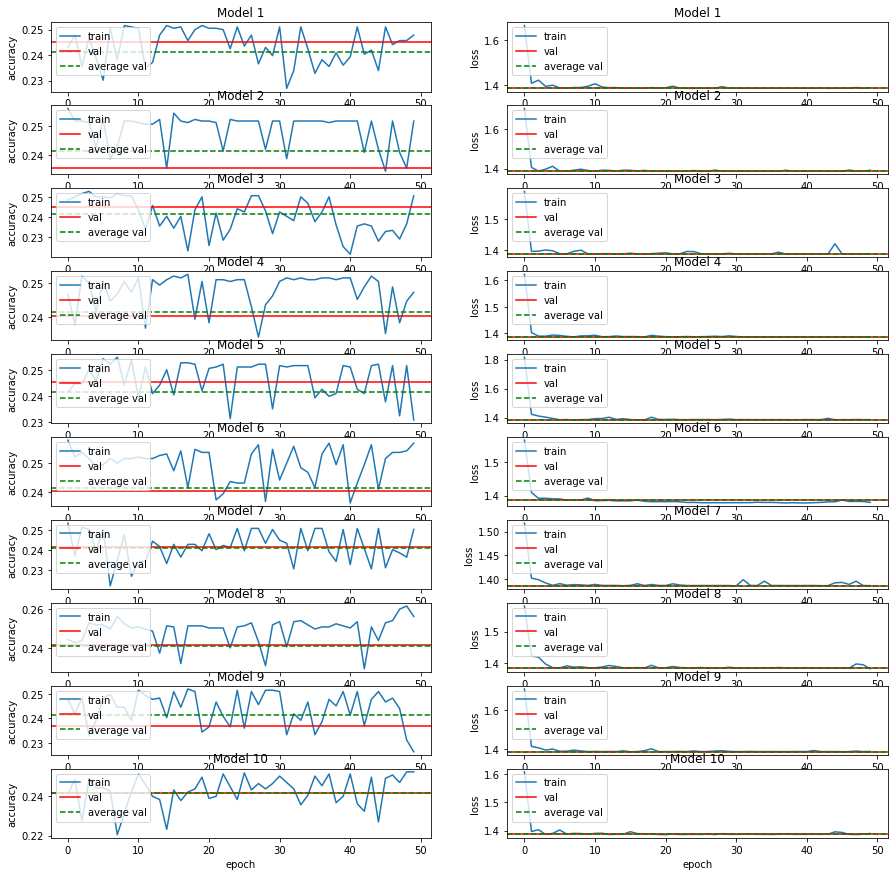

In [92]:
fig, axs = plt.subplots(n_split, 2,figsize=(15,15))

for i in range(n_split):
  axs[i][0].plot(history[i].history['accuracy'])
  axs[i][0].axhline(eval[i][1], color='r')
  axs[i][0].axhline( np.average([x[1] for x in eval]), color='g', linestyle='--')
  axs[i][0].set(title = 'Model ' + str(i+1), ylabel = 'accuracy', xlabel = 'epoch')
  axs[i][0].legend(['train', 'val', 'average val'], loc='upper left')
  axs[i][1].plot(history[i].history['loss'])
  axs[i][1].axhline(eval[i][0], color='r')
  axs[i][1].axhline(np.average([x[0] for x in eval]), color='g', linestyle='--')
  axs[i][1].set(title = 'Model ' + str(i+1), ylabel = 'loss', xlabel = 'epoch')
  axs[i][1].legend(['train', 'val', 'average val'], loc='upper left')

In [10]:
data = pd.read_csv('dataset/preprocessed/channel_pca98_df_flat_42x640')
label = pd.read_csv('dataset/preprocessed/label')


In [11]:
X = np.array(data)
Y = np.array(label)
X = X[:, 1:].reshape(2076, 42, 640, 1)
Y = Y[:, 1:]

In [12]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, LeakyReLU, Activation, BatchNormalization, MaxPool2D
class Conv(Model):
    def __init__(self):
        """
        init: constructor of model
        call: performs forward pass of model
        """
        super(Conv, self).__init__()

        self.layer_list = [
            #Conv2D(filters=32, kernel_size=(3,3), padding = 'same'),
            #BatchNormalization(),
            #LeakyReLU(),
            #MaxPool2D(),
            Conv2D(filters=16, kernel_size=(3,3), padding = 'same'),
            BatchNormalization(),
            LeakyReLU(),
            Dropout(0.3),
            MaxPool2D(),
            Conv2D(filters=8, kernel_size=(3,3), padding = 'same'),
            BatchNormalization(),
            LeakyReLU(),
            tf.keras.layers.GlobalAveragePooling2D(),
            Dense(4, activation='softmax')
        ]

    @tf.function
    def call(self, inputs) -> tf.Tensor:
        """ Computes a forward step with the given data
        Parameters
        ----------
        inputs : tf.Tensor
            the input for the model
        training : bool
            true if call has been made from train_step, which tells the dropout layer to be active
        Returns
        ----------
        x : tf.Tensor
            the output of the model
        """
        x = inputs
        for layer in self.layer_list:
            x = layer(x)
        return x

In [13]:
n_split = 10

In [ ]:
history = []
eval = []
for train_index,test_index in KFold(n_split).split(X):
  x_train,x_test= X[train_index],X[test_index]
  y_train,y_test= Y[train_index],Y[test_index]

  model = Conv()
  model.compile(loss = 'sparse_categorical_crossentropy' , optimizer = 'adam' , metrics = ['accuracy'] )
  temp = model.fit(x_train, y_train, batch_size= 15, epochs= 10)
  history.append(temp)
  eval.append(model.evaluate(x_test,y_test))
  #print('Model evaluation ',model.evaluate(x_test,y_test))

Epoch 1/10
125/125 [==============================] - 17s 133ms/step - loss: 1.4009 - accuracy: 0.2484
Epoch 2/10
125/125 [==============================] - 32s 256ms/step - loss: 1.3901 - accuracy: 0.2548
Epoch 3/10
100/125 [=======================>......] - ETA: 3s - loss: 1.3900 - accuracy: 0.2393

In [ ]:
fig, axs = plt.subplots(n_split, 2,figsize=(15,15))

for i in range(n_split):
  axs[i][0].plot(history[i].history['accuracy'])
  axs[i][0].axhline(eval[i][1], color='r')
  axs[i][0].axhline( np.average([x[1] for x in eval]), color='g', linestyle='--')
  axs[i][0].set(title = 'Model ' + str(i+1), ylabel = 'accuracy', xlabel = 'epoch')
  axs[i][0].legend(['train', 'val', 'average val'], loc='upper left')
  axs[i][1].plot(history[i].history['loss'])
  axs[i][1].axhline(eval[i][0], color='r')
  axs[i][1].axhline(np.average([x[0] for x in eval]), color='g', linestyle='--')
  axs[i][1].set(title = 'Model ' + str(i+1), ylabel = 'loss', xlabel = 'epoch')
  axs[i][1].legend(['train', 'val', 'average val'], loc='upper left')